# Lane Detection Using Asphalt 8 Airborne
## 5 simple steps to implement lane detection using Python

Lane detection and control has become a common feature in many vehicles today. Additionally it is a basic starting point for anyone going in the direction of Autonomous Driving. But for most people who are not working on autonomous driving or computer vision, starting with it might appear much more of a daunting task than it actually is.
There is a lot of technical research involved in doing actual lane detection. In this case we see a practical perspective so that anyone interested can try it out without much hassle. The detailed links to the theory are still there in the relevant sections for the curious ones: those of you who do not get satiated with just practical applications and like to get their teeth sink deeper into the subject matter.

This project is meant for beginners to lane detection, as a fun project for trial.

In [1]:
# import libraries
from PIL import ImageGrab
import cv2
import numpy as np
import time
import pyautogui

### Draw lanes function

This function extrapolates and merges the lines detected by the Hough Transform in edgeprocessing function. Source code for the for this function is here: https://codynicholson.github.io/Finding_Lane_Lines_Project/

I adapted this methodology and applied this function in this project.

In [2]:
def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)



def draw_lines(img, lines, color=[0, 255, 255], thickness=3): 

    # initialize lists to hold line formula values
    bLeftValues     = []  # b of left lines
    bRightValues    = []  # b of Right lines
    mPositiveValues = []  # m of Left lines
    mNegitiveValues = []  # m of Right lines
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # calculate slope and intercept
            m = (y2-y1)/(x2-x1)
            b = y1 - x1*m
            
            # threshold to check for outliers
            if m >= 0 and (m < 0.2 or m > 0.8):
                continue
            elif m < 0 and (m < -0.8 or m > -0.2):
                continue
                
            # seperate positive line and negative line slopes
            if m > 0:
                mPositiveValues.append(m)
                bLeftValues.append(b)
            else:
                mNegitiveValues.append(m)
                bRightValues.append(b)
    
    # Get image shape and define y region of interest value
    imshape = img.shape
    y_max   = imshape[0] # lines initial point at bottom of image    
    y_min   = 330        # lines end point at top of ROI

    # Get the mean of all the lines values
    AvgPositiveM = mean(mPositiveValues)
    AvgNegitiveM = mean(mNegitiveValues)
    AvgLeftB     = mean(bLeftValues)
    AvgRightB    = mean(bRightValues)

    # use average slopes to generate line using ROI endpoints
    if AvgPositiveM != 0:
        x1_Left = (y_max - AvgLeftB)/AvgPositiveM
        y1_Left = y_max
        x2_Left = (y_min - AvgLeftB)/AvgPositiveM
        y2_Left = y_min
    if AvgNegitiveM != 0:
        x1_Right = (y_max - AvgRightB)/AvgNegitiveM
        y1_Right = y_max
        x2_Right = (y_min - AvgRightB)/AvgNegitiveM
        y2_Right = y_min

        # define average left and right lines
        cv2.line(img, (int(x1_Left), int(y1_Left)), (int(x2_Left), int(y2_Left)), color, thickness) #avg Left Line
        cv2.line(img, (int(x1_Right), int(y1_Right)), (int(x2_Right), int(y2_Right)), color, thickness) #avg Right Line

### Overlay lines

Used to draw the generated lines on the image

In [3]:
def overlay_lines(image, lines):
    
    for line in lines:
        coordinates = line[0]
        cv2.line(image,(coordinates[0],coordinates[1]),(coordinates[2],coordinates[3]),[255,255,255],3)            

### Required region

Creates a mask to hide the unnecessary contents in the image. It is drawn according to the game window size and the game scene.


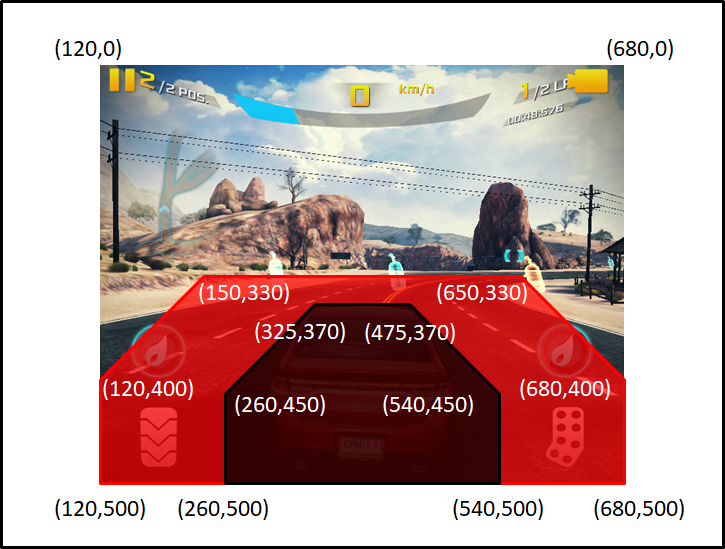

The vertices are selected accordingly.

In [4]:
def required_region(image, vertices):
    
    mask = np.zeros_like(image) # black image        
    cv2.fillPoly(mask, vertices, 255) # fill within vertices
    masked = cv2.bitwise_and(image, mask) # intersection of mask and image
    
    return masked


vertices = np.array([[120,500],[120,400],[150,330],\
                     [650,330],[680,400],[680,500],\
                     [260,500],[260,450],[325,370],\
                     [475,370], [540,450],[540,500]], np.int32)


### Processing the image for getting the edges
Processing carried out here is:
1. Canny
2. Gaussian Blur
3. Masking
4. Hough Line Transform

In [5]:
def edgeprocessed(image):
    
    original_image = image
    
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)    
    edgeprocessed_img = cv2.Canny(gray_image, threshold1 = 200, threshold2 = 300)    
    edgeprocessed_img = cv2.GaussianBlur(edgeprocessed_img,(5,5),0)    
    edgeprocessed_img = required_region(edgeprocessed_img, [vertices])    
    lines = cv2.HoughLinesP(edgeprocessed_img, 1, np.pi/180, 180, np.array([]), 100, 5)
    #overlay_lines(edgeprocessed_img, lines)
    
    m1 = 0
    m2 = 0
    
    try:
        l1, l2, m1, m2 = draw_lines(original_image,lines)
        cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 30)
        cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 30)
    
    except Exception as e:
        pass
    
    try:
        for coords in lines:
            coords = coords[0]
            try:
                cv2.line(edgeprocessed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 2)
                
                
            except Exception as e:
                print(str(e))
    except Exception as e:
        pass

    return edgeprocessed_img,original_image, m1, m2

### Screen Capture
Captures the screen continuously and displays the processed image

In [6]:
def screen_capture(processing = None): 
    # takes in a list for type of processing
    # [processing_function, masking_function]    
    last_time = time.time()
    
    while True:
        
        screen = np.array(ImageGrab.grab(bbox=(0,40,800,700)))        
        count = 0
            
        if processing is not None:
            
            for i in processing:
                count += 1
            
            processed_screen ,original_image, m1, m2 = processing[0](screen)

            if count > 1:      
                
                masked_screen = processing[1](processed_screen, [vertices])
                screen_1 = masked_screen
                
            else:
                
                screen_1 = processed_screen
    
        else:
            
            screen_1 = screen                
        
        cv2.imshow('Python Window 2', screen_1)
        cv2.imshow('Python Window', cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))                
                
        print(f'the screen rate is {(1/(time.time()-last_time))}')
        last_time = time.time()
         
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break


In [7]:
screen_capture([edgeprocessed])  

the screen rate is 3.1642085600952363
the screen rate is 4.804763633989234
the screen rate is 5.103528163495748
the screen rate is 6.711981795429014
the screen rate is 5.778161674856624
the screen rate is 6.453619319449467
the screen rate is 6.673408537652543
the screen rate is 7.106496534266791
the screen rate is 6.212872482406284
the screen rate is 8.345561593301749
the screen rate is 5.4429845222291
the screen rate is 6.22632860281456
the screen rate is 5.795759204626322
the screen rate is 6.95474767238449
the screen rate is 5.1273166909322505
the screen rate is 7.090937984994134
the screen rate is 6.210223175749607
the screen rate is 7.933990352785397
the screen rate is 6.287293811496789
the screen rate is 7.520204827356213
the screen rate is 4.30840344852735
the screen rate is 7.300993587288767
the screen rate is 6.331034461938811
the screen rate is 7.635169476098591
the screen rate is 5.556061284451309
the screen rate is 6.760851799136337
the screen rate is 6.0295388613996606
the

the screen rate is 8.151845790850537
the screen rate is 9.370861726133292
the screen rate is 8.643665274932715
the screen rate is 8.425884111308429
the screen rate is 8.642240473413747
the screen rate is 8.98715234626098
the screen rate is 10.127793151075245
the screen rate is 6.684394806502868
the screen rate is 5.932923499973124
the screen rate is 7.566042943291261


KeyboardInterrupt: 